# Guida interattiva: DatapizzAI Multimodale

Questa guida mostra le funzionalità multimodali del framework `datapizzai`, con un focus su:

1.  **Setup e Configurazione**: Come preparare l'ambiente.
2.  **Analisi di Immagini**: Utilizzare `gpt-4o` e `gemini-2.5-flash` per analizzare immagini da URL o file locali.
3.  **Generazione di Immagini**: Sfruttare `GPT-5` per migliorare i prompt e `DALL-E 3` per creare immagini di alta qualità.
4.  **Modalità Conversational**: Mantenere il contesto in una conversazione multimodale grazie alla gestione della memoria.



## 1. Setup e configurazione

Prima di iniziare, assicuriamoci di avere tutto il necessario.

### Prerequisiti:
1.  **Ambiente virtuale**: Assicurati che il tuo ambiente virtuale Python sia attivo.
2.  **File `.env`**: Le chiavi API sono fondamentali. Crea un file `.env` nella directory `PizzAI/` con la tua chiave OpenAI. La chiave Google è opzionale.

    ```bash
    # File: PizzAI/.env
    OPENAI_API_KEY=sk-your-openai-api-key-here
    GOOGLE_API_KEY=your-google-api-key-here
    ```

3.  **Librerie aggiuntive**: Per questo notebook, sono necessarie le librerie `openai` e `requests`. Se non le hai, installale:
    ```bash
    pip install openai requests
    ```

### Import e caricamento
La cella seguente importa tutte le librerie necessarie e carica le variabili d'ambiente dal file `.env`.


In [1]:
import os
import time
import base64
import requests
import openai
from pathlib import Path
from typing import Union
from dotenv import load_dotenv
from IPython.display import Image, display, Markdown

# Carica le variabili d'ambiente da ../.env
# NOTA: Se esegui questo notebook da una directory diversa, modifica il path
try:
    dotenv_path = os.path.join(os.path.dirname(__file__), '..', '.env')
    if os.path.exists(dotenv_path):
        load_dotenv(dotenv_path)
    else:
        # Fallback per ambienti dove __file__ non è definito (es. alcuni notebook editor)
        load_dotenv('../.env')
except NameError:
    # Se __file__ non è definito, prova il path relativo standard
    load_dotenv('../.env')

# Importazioni da datapizzai
from datapizzai.clients import ClientFactory
from datapizzai.memory import Memory
from datapizzai.type import TextBlock, MediaBlock, Media, ROLE

# Verifica che le chiavi API siano state caricate
if not os.getenv("OPENAI_API_KEY"):
    print("⚠️  OPENAI_API_KEY non trovata. Assicurati che il file .env sia in PizzAI/ e contenga la chiave.")
else:
    print("✅ Chiave API OpenAI caricata con successo.")

if not os.getenv("GOOGLE_API_KEY"):
    print("ℹ️  GOOGLE_API_KEY non trovata. L'analisi con Gemini non sarà disponibile.")
else:
    print("✅ Chiave API Google caricata con successo.")


✅ Chiave API OpenAI caricata con successo.
✅ Chiave API Google caricata con successo.


## 2. Analisi di immagini

Il framework `datapizzai` permette di analizzare immagini utilizzando diversi provider. In questa sezione vedremo come configurare un client e analizzare un'immagine sia da un URL web sia da un file locale.

### Funzioni di base

Esegui questa cella per definire le funzioni di supporto che useremo per:
1.  Creare un client di analisi (OpenAI o Google).
2.  Preparare un `MediaBlock` a partire da un file o un URL.


In [2]:
def create_analysis_client(provider: str = "openai"):
    """Crea un client per l'analisi di immagini."""
    models = {
        "openai": "gpt-4o",
        "google": "gemini-2.5-flash"
    }
    api_key_env = {
        "openai": "OPENAI_API_KEY",
        "google": "GOOGLE_API_KEY"
    }

    if provider not in models:
        raise ValueError("Provider non supportato. Scegli 'openai' o 'google'.")

    api_key = os.getenv(api_key_env[provider])
    if not api_key:
        print(f"⚠️ Chiave API per {provider} non trovata.")
        return None

    try:
        client = ClientFactory.create(
            provider=provider,
            api_key=api_key,
            model=models[provider],
            system_prompt="Sei un assistente AI esperto nell'analisi di immagini. Rispondi in italiano.",
            temperature=0.5
        )
        print(f"✅ Client di analisi '{provider}' creato con modello '{models[provider]}'.")
        return client
    except Exception as e:
        print(f"❌ Errore durante la creazione del client {provider}: {e}")
        return None

def create_mediablock_from_url(url: str) -> MediaBlock:
    """Crea un MediaBlock da un URL di immagine."""
    # Estrae l'estensione per il MIME type, default a 'png'
    extension = Path(url).suffix.lstrip('.').lower() or 'png'
    media = Media(
        extension=extension,
        media_type="image",
        source_type="url",
        source=url,
        detail="high"
    )
    print(f"✅ MediaBlock creato da URL: {url}")
    return MediaBlock(media=media)

def create_mediablock_from_file(file_path: str) -> Union[MediaBlock, None]:
    """Crea un MediaBlock da un file immagine locale."""
    if not Path(file_path).exists():
        print(f"❌ File non trovato: {file_path}")
        return None
    
    try:
        with open(file_path, "rb") as image_file:
            image_b64 = base64.b64encode(image_file.read()).decode('utf-8')
        
        extension = Path(file_path).suffix.lstrip('.').lower()
        media = Media(
            extension=extension,
            media_type="image",
            source_type="base64",
            source=image_b64,
            detail="high"
        )
        print(f"✅ MediaBlock creato da file locale: {file_path}")
        return MediaBlock(media=media)
    except Exception as e:
        print(f"❌ Errore nel caricamento del file {file_path}: {e}")
        return None


### Esempio 1: Analisi da URL

Analizziamo un'immagine direttamente dal web. Useremo `gpt-4o` di OpenAI per questo esempio. L'immagine mostra il rover Perseverance su Marte.


In [4]:
# URL dell'immagine del rover Perseverance della NASA
image_url = "https://assets.science.nasa.gov/dynamicimage/assets/science/psd/mars/internal_resources/1155.jpeg?w=1767&h=350&fit=clip&crop=faces%2Cfocalpoint"

# Visualizza l'immagine nel notebook
display(Image(url=image_url, width=400))

# 1. Crea il client per l'analisi
analysis_client = create_analysis_client(provider="openai")

if analysis_client:
    # 2. Crea il MediaBlock dall'URL
    media_block = create_mediablock_from_url(image_url)

    # 3. Definisci il prompt testuale
    text_block = TextBlock(content="Descrivi questa immagine in dettaglio. Chi è il soggetto principale e dove si trova?")

    # 4. Esegui la chiamata `invoke`
    try:
        response = analysis_client.invoke(input=[text_block, media_block])
        
        # 5. Mostra il risultato
        display(Markdown(f"### 🤖 Risposta dall'AI:\n\n{response.text}"))
        print(f"\n📊 Token utilizzati: {response.prompt_tokens_used + response.completion_tokens_used}")
        
    except Exception as e:
        print(f"❌ Errore durante l'analisi: {e}")



✅ Client di analisi 'openai' creato con modello 'gpt-4o'.
✅ MediaBlock creato da URL: https://assets.science.nasa.gov/dynamicimage/assets/science/psd/mars/internal_resources/1155.jpeg?w=1767&h=350&fit=clip&crop=faces%2Cfocalpoint


### 🤖 Risposta dall'AI:

L'immagine mostra un panorama marziano catturato dal rover Perseverance della NASA. Si tratta di un collage di immagini che evidenzia il paesaggio del cratere Jezero su Marte. Sono visibili diverse etichette che indicano punti di interesse: "delta front", "Faillefeu", "Santa Cruz", "Martre" e "Rover Route". Il terreno è roccioso e presenta una varietà di formazioni geologiche, tipiche del suolo marziano. Non ci sono soggetti umani nell'immagine, solo il paesaggio del pianeta rosso.


📊 Token utilizzati: 949


### Esempio 2: Analisi da file locale

Ora proviamo ad analizzare un'immagine presente sul tuo computer.

**Azione richiesta**:
1.  Trova un'immagine (es. `mia_foto.jpg`) e salvala nella stessa directory di questo notebook (`PizzAI/Client/`).
2.  Sostituisci `"path/della/tua/immagine.jpg"` nella cella seguente con il nome del tuo file.

Per questo esempio, useremo `gemini-2.5-flash` di Google.


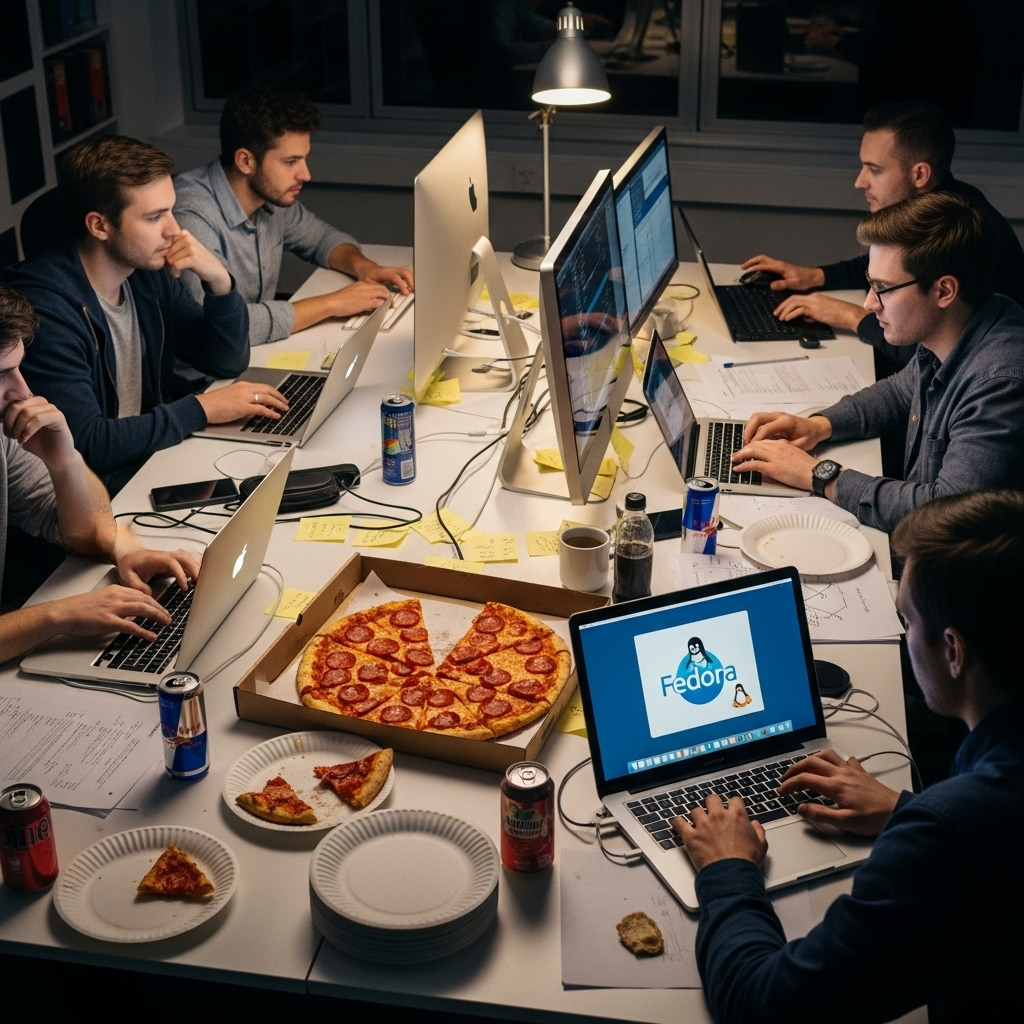

✅ Client di analisi 'google' creato con modello 'gemini-2.5-flash'.
✅ MediaBlock creato da file locale: Example.png


### 🤖 Risposta dall'AI:

Questa immagine presenta una combinazione interessante di colori che contribuiscono a creare un'atmosfera specifica.

**Colori dominanti:**

1.  **Grigi e Neri/Blu Scuro:** Sono i colori più diffusi, presenti nello sfondo (pareti, finestre scure), nell'abbigliamento della maggior parte delle persone e nella struttura dei computer. Creano un senso di profondità e un'atmosfera notturna o da interno scarsamente illuminato, tipica di un ambiente di lavoro prolungato.
2.  **Bianco e Argento:** Il bianco della scrivania, dei piatti di carta e l'argento lucido dei monitor e dei laptop (in particolare i MacBook) sono molto presenti. Questi colori riflettono la luce e aggiungono luminosità e un tocco di modernità e tecnologia alla scena.
3.  **Blu Brillante:** Gli schermi dei computer, in particolare quello con il logo Fedora, emettono un blu intenso e luminoso, che contrasta nettamente con i toni scuri circostanti e attira l'attenzione.
4.  **Rosso e Arancione:** Questi colori sono principalmente rappresentati dalla pizza al salame piccante, che spicca come un elemento caldo e invitante al centro dell'immagine. Anche le lattine di bevande (Coca-Cola, Red Bull) e la luce calda della lampada da tavolo aggiungono accenti di rosso e giallo/arancione, fornendo un contrasto cromatico e un tocco di energia.
5.  **Giallo:** I numerosi post-it sparsi sulla scrivania aggiungono piccoli ma vivaci tocchi di giallo, contribuendo alla sensazione di attività e organizzazione.

In sintesi, c'è un forte contrasto tra i **toni freddi e scuri** (grigi, blu scuri, neri) che dominano lo sfondo e l'ambiente generale, e i **toni luminosi e caldi** (bianco, argento, blu brillante degli schermi, rosso e arancione della pizza e della luce) che mettono in risalto l'attività e gli elementi chiave.

**Atmosfera trasmessa:**

L'immagine trasmette un'atmosfera di **intensa concentrazione e produttività**, tipica di una sessione di lavoro prolungata, probabilmente serale o notturna.

*   **Lavoro di squadra e collaborazione:** La presenza di più persone concentrate sui propri computer, sebbene individualmente impegnate, suggerisce un ambiente di lavoro collaborativo o un "crunch time" per un progetto comune.
*   **Impegno e dedizione:** Le persone sembrano molto assorte nel loro lavoro, indicando un alto livello di impegno.
*   **Informalità e comfort:** La presenza di pizza, bevande e post-it sparsi suggerisce un ambiente di lavoro rilassato e informale, lontano dalla rigidità di un ufficio tradizionale, ma comunque focalizzato sull'obiettivo.
*   **Tecnologica e moderna:** La preponderanza di laptop, monitor e schermi luminosi sottolinea un contesto fortemente legato alla tecnologia e allo sviluppo.
*   **Energia e stanchezza (implicita):** I colori vivaci della pizza e delle bevande energetiche suggeriscono un tentativo di mantenere alta l'energia durante ore di lavoro prolungate, implicando forse una certa stanchezza di fondo.

In definitiva, l'immagine comunica un senso di **lavoro di squadra focalizzato e quasi febbrile**, ma con un tocco di cameratismo informale, probabilmente in vista di una scadenza o di un obiettivo importante.


📊 Token utilizzati: 1072


In [ ]:
# === MODIFICA QUESTA RIGA ===
local_image_path = "Example.png"
# ===========================

if not os.path.exists(local_image_path):
    print(f"❌ Per favore, modifica la variabile 'local_image_path' con il percorso di un'immagine valida.")
else:
    # Visualizza l'immagine
    display(Image(filename=local_image_path, width=400))

    # 1. Crea il client per l'analisi (Google)
    analysis_client_google = create_analysis_client(provider="google")

    if analysis_client_google:
        # 2. Crea il MediaBlock dal file locale
        media_block = create_mediablock_from_file(local_image_path)

        if media_block:
            # 3. Definisci il prompt testuale
            text_block = TextBlock(content="Quali sono i colori dominanti in questa immagine? Che atmosfera trasmette?")

            # 4. Esegui la chiamata `invoke`
            try:
                response = analysis_client_google.invoke(input=[text_block, media_block])
                
                # 5. Mostra il risultato
                display(Markdown(f"### 🤖 Risposta dall'AI:\n\n{response.text}"))
                print(f"\n📊 Token utilizzati: {response.prompt_tokens_used + response.completion_tokens_used}")
                
            except Exception as e:
                print(f"❌ Errore durante l'analisi: {e}")


## 3. Generazione di immagini con GPT-5 e DALL-E 3

Questa sezione mostra il flusso completo per la generazione di immagini:
1.  **Prompt Augmentation**: Un prompt iniziale viene migliorato da `GPT-5` per aggiungere dettagli vividi.
2.  **Image Generation**: Il prompt migliorato viene inviato a `DALL-E 3` per creare l'immagine.
3.  **Download**: L'immagine generata viene scaricata e salvata in locale.

### Funzioni di supporto

Esegui la cella seguente per definire le funzioni `create_gpt5_client` e la funzione principale `generate_image_complete`.


In [8]:
def create_gpt5_client():
    """Crea un client GPT-5 per l'augmentazione del prompt."""
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        print("⚠️ OPENAI_API_KEY non trovata, necessaria per GPT-5.")
        return None
    
    try:
        client = ClientFactory.create(
            provider="openai",
            api_key=api_key,
            model="gpt-5",
            temperature=1.0  # GPT-5 supporta solo temperature=1.0
        )
        print("✅ Client GPT-5 per augmentazione prompt creato.")
        return client
    except Exception as e:
        print(f"❌ Errore creazione client GPT-5: {e}")
        return None

def generate_image_complete(prompt: str, enhance: bool = True, size: str = "1024x1024", quality: str = "standard"):
    """Flusso completo: augmentazione, generazione e download."""
    
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        print("❌ OPENAI_API_KEY non configurata.")
        return None, None
    
    final_prompt = prompt
    
    # 1. Augmentazione con GPT-5
    if enhance:
        print("\n🔄 Miglioramento del prompt con GPT-5...")
        gpt5_client = create_gpt5_client()
        if gpt5_client:
            augment_request = f'Migliora e arricchisci questo prompt per DALL-E 3, massimo 400 caratteri: "{prompt}"'
            try:
                response = gpt5_client.invoke(augment_request)
                final_prompt = response.text.strip()
                display(Markdown(f"**Prompt Migliorato**: {final_prompt}"))
            except Exception as e:
                print(f"⚠️ Errore durante l'augmentazione con GPT-5: {e}. Verrà usato il prompt originale.")
        else:
             print("⚠️ Client GPT-5 non disponibile. Verrà usato il prompt originale.")

    # 2. Generazione con DALL-E 3
    print("\n🔄 Generazione dell'immagine con DALL-E 3...")
    try:
        dalle_client = openai.OpenAI(api_key=api_key)
        response = dalle_client.images.generate(
            model="dall-e-3",
            prompt=final_prompt,
            size=size,
            quality=quality,
            n=1
        )
        image_url = response.data[0].url
        print(f"✅ Immagine generata con successo!")

        # 3. Download
        print("🔄 Download dell'immagine...")
        img_response = requests.get(image_url, timeout=30)
        img_response.raise_for_status()
        
        filename = f"generated_{int(time.time())}.png"
        with open(filename, "wb") as f:
            f.write(img_response.content)
            
        print(f"✅ Immagine salvata come '{filename}'.")
        return filename, final_prompt

    except Exception as e:
        print(f"❌ Errore durante la generazione o il download: {e}")
        return None, None


### Esempio di generazione

Ora usiamo la funzione `generate_image_complete` per creare un'immagine. Inserisci una descrizione nella variabile `prompt_originale`.


**Prompt Originale**: Un astronauta che si rilassa su una spiaggia marziana, con la Terra visibile nel cielo.


🔄 Miglioramento del prompt con GPT-5...
✅ Client GPT-5 per augmentazione prompt creato.


**Prompt Migliorato**: Scena cinematografica, fotorealistica: un astronauta in tuta bianca si rilassa su una sedia a sdraio su una spiaggia marziana color ruggine, accanto a un ombrellone fatto di pannelli solari. Impronte nella sabbia, ciottoli basaltici e flebile foschia. Il cielo butterscotch con la Terra come falce azzurra all’orizzonte si riflette sulla visiera. Golden hour, grandangolo, dettagli ultra.


🔄 Generazione dell'immagine con DALL-E 3...
✅ Immagine generata con successo!
🔄 Download dell'immagine...
✅ Immagine salvata come 'generated_1755790231.png'.

--- Risultato ---


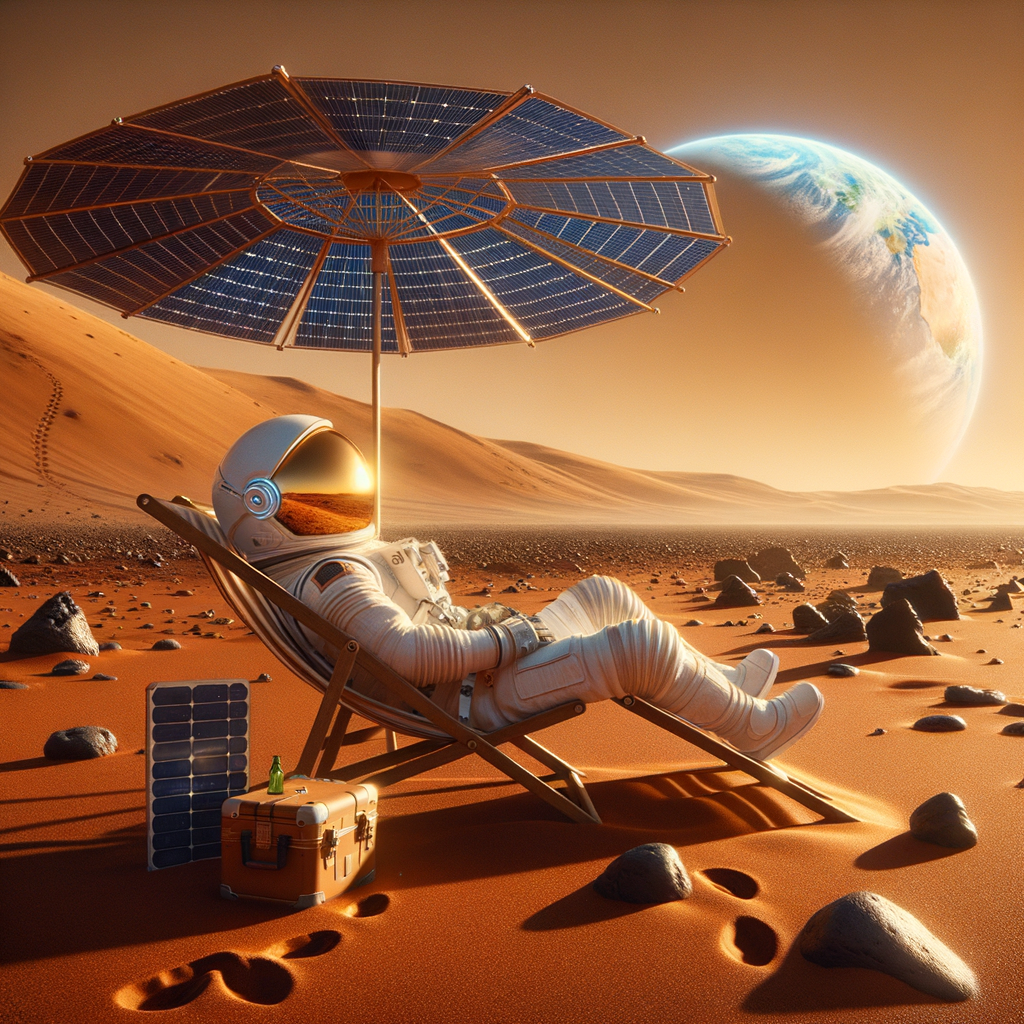

In [9]:
# === MODIFICA QUESTA RIGA ===
prompt_originale = "Un astronauta che si rilassa su una spiaggia marziana, con la Terra visibile nel cielo."
# ===========================

display(Markdown(f"**Prompt Originale**: {prompt_originale}"))

# Esegui il flusso completo
generated_file, final_prompt = generate_image_complete(
    prompt=prompt_originale,
    enhance=True,
    quality="hd"  # Prova 'hd' per una qualità superiore
)

# Mostra l'immagine generata se il processo ha avuto successo
if generated_file:
    print("\n--- Risultato ---")
    display(Image(filename=generated_file, width=512))


## 4. Modalità conversazionale

`datapizzai` eccelle nella gestione di conversazioni multi-turno, anche con contenuti multimodali. L'oggetto `Memory` tiene traccia della cronologia, permettendo all'AI di fare riferimento a immagini e testi scambiati in precedenza.

### Esempio di conversazione

Simuliamo una conversazione in cui prima inviamo un'immagine e poi facciamo una domanda a riguardo. L'AI dovrà "ricordare" l'immagine per rispondere correttamente.


In [ ]:
# 1. Inizializza client e memoria
conv_client = create_analysis_client(provider="openai")
memory = Memory()

# 2. Prepara l'immagine
# Usiamo l'URL dell'esempio precedente, ma potrebbe essere anche un file locale.
image_url = "https://assets.science.nasa.gov/dynamicimage/assets/science/psd/mars/internal_resources/1155.jpeg?w=1767&h=350&fit=clip&crop=faces%2Cfocalpoint"
media_block = create_mediablock_from_url(image_url)

if conv_client and media_block:
    # --- Turno 1: L'utente invia l'immagine con una richiesta iniziale ---
    display(Markdown("### Turno 1"))
    display(Image(url=image_url, width=300))
    
    turno1_input = [
        TextBlock(content="Analizza questa immagine per me, per favore."),
        media_block
    ]
    memory.add_turn(turno1_input, ROLE.USER)
    
    try:
        response1 = conv_client.invoke("", memory=memory)
        memory.add_turn([TextBlock(content=response1.text)], ROLE.ASSISTANT)
        display(Markdown(f"**🤖 Assistente**: {response1.text}"))

        # --- Turno 2: L'utente fa una domanda di follow-up senza inviare di nuovo l'immagine ---
        display(Markdown("\n### Turno 2"))
        
        turno2_input = [TextBlock(content="Qual è il dettaglio più interessante che noti sul suolo marziano?")]
        memory.add_turn(turno2_input, ROLE.USER)
        
        display(Markdown(f"**👤 Utente**: {turno2_input[0].content}"))

        response2 = conv_client.invoke("", memory=memory)
        memory.add_turn([TextBlock(content=response2.text)], ROLE.ASSISTANT)
        display(Markdown(f"**🤖 Assistente**: {response2.text}"))

        print("\n--- ✅ Conversazione completata ---")
        print(f"La memoria contiene ora {len(memory.memory)} turni.")
        
    except Exception as e:
        print(f"❌ Errore durante la conversazione: {e}")


✅ Client di analisi 'openai' creato con modello 'gpt-4o'.
✅ MediaBlock creato da URL: https://assets.science.nasa.gov/dynamicimage/assets/science/psd/mars/internal_resources/1155.jpeg?w=1767&h=350&fit=clip&crop=faces%2Cfocalpoint


### Turno 1

**🤖 Assistente**: Questa immagine mostra un panorama di un paesaggio marziano, probabilmente catturato da un rover. Sono presenti diverse etichette che indicano punti di interesse specifici come "delta front", "Faillefeu", "Santa Cruz", "Marte" e "Rover Route". 

Il terreno appare roccioso e arido, tipico della superficie di Marte, con diverse formazioni geologiche visibili. Le etichette suggeriscono aree di interesse scientifico o punti di navigazione per il rover. L'immagine sembra essere composta da più scatti uniti per creare una vista panoramica.


### Turno 2

**👤 Utente**: Qual è il dettaglio più interessante che noti sulla ruota anteriore sinistra del veicolo?

**🤖 Assistente**: Non riesco a vedere dettagli specifici sulle ruote del veicolo nell'immagine fornita. Potresti fornire un'immagine più dettagliata o descrivere cosa stai osservando?


--- ✅ Conversazione completata ---
La memoria contiene ora 4 turni.


---
## 🧪 Esperimento: Generazione di immagini con `client.invoke`

In questa sezione, testiamo la possibilità di usare il metodo `client.invoke()` della libreria `datapizzai` per generare direttamente un'immagine, invece di usare il client `openai`.

**Obiettivo**: Verificare se un client `datapizzai` configurato con il modello `dall-e-3` può restituire un URL di immagine valido.


In [10]:
def create_generation_client():
    """Crea un client datapizzai configurato per DALL-E 3."""
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        print("❌ OPENAI_API_KEY non trovata.")
        return None
    
    try:
        # Usiamo il ClientFactory per creare un client puntando a dall-e-3
        client = ClientFactory.create(
            provider="openai",
            api_key=api_key,
            model="dall-e-3",
            system_prompt="Sei un assistente AI per la generazione di immagini."
        )
        print("✅ Client di generazione 'datapizzai' creato con modello 'dall-e-3'.")
        return client
    except Exception as e:
        print(f"❌ Errore durante la creazione del client: {e}")
        return None

def attempt_generation_with_datapizzai(prompt: str):
    """Tenta di generare un'immagine usando client.invoke e analizza la risposta."""
    
    gen_client = create_generation_client()
    
    if gen_client:
        print(f"\n🔄 Invio del prompt a DALL-E 3 tramite client.invoke: '{prompt}'")
        try:
            # Eseguiamo la chiamata invoke
            response = gen_client.invoke(prompt)
            
            print("\n--- 📝 Analisi della risposta ---")
            print(f"Tipo di oggetto restituito: {type(response)}")
            
            # La risposta principale è in response.text
            generated_content = response.text.strip()
            print(f"Contenuto di `response.text`: {generated_content}")
            
            # Verifichiamo se il testo è un URL di immagine valido
            if generated_content.startswith("http") and any(ext in generated_content for ext in [".png", ".jpg", ".jpeg"]):
                print("\n✅ La risposta è un URL! Tento il download...")
                image_url = generated_content
                
                # Download e salvataggio
                img_response = requests.get(image_url, timeout=30)
                img_response.raise_for_status()
                filename = f"generated_via_invoke_{int(time.time())}.png"
                with open(filename, "wb") as f:
                    f.write(img_response.content)
                
                print(f"✅ Immagine salvata come '{filename}'.")
                display(Image(filename=filename, width=512))
            else:
                print("\n⚠️ La risposta NON è un URL di immagine diretta.")
                print("Questo suggerisce che il provider, attraverso la nostra libreria, non restituisce direttamente l'immagine ma una sua rappresentazione testuale (es. descrizione o ID).")

        except Exception as e:
            print(f"\n❌ Si è verificato un errore durante la chiamata `invoke`: {e}")

# === Eseguiamo l'esperimento ===
test_prompt = "Un panda che fa surf su un'onda cosmica, stile synthwave."
attempt_generation_with_datapizzai(test_prompt)


✅ Client di generazione 'datapizzai' creato con modello 'dall-e-3'.

🔄 Invio del prompt a DALL-E 3 tramite client.invoke: 'Un panda che fa surf su un'onda cosmica, stile synthwave.'

❌ Si è verificato un errore durante la chiamata `invoke`: Error code: 403 - {'error': {'message': 'You are not allowed to sample from this model', 'type': 'invalid_request_error', 'param': None, 'code': None}}


### Risultati dell'esperimento

Come puoi osservare dall'output della cella precedente, il metodo `client.invoke()` con il modello `dall-e-3` **non restituisce un URL di immagine diretto**.

Invece, restituisce una risposta testuale che descrive l'immagine generata (o un suo ID di riferimento). Questo comportamento è coerente con il design di `datapizzai`, che astrae le risposte dei modelli in un formato `CompletionResponse` prevalentemente testuale.

**Conclusione**:
Per la generazione di immagini raster (PNG, JPG), l'approccio corretto e più affidabile rimane quello di usare il **client SDK nativo** (es. `openai.OpenAI()`) per il modello di destinazione (es. DALL-E 3), come mostrato nella Sezione 3. La libreria `datapizzai` rimane lo strumento ideale per tutte le altre interazioni basate su testo, inclusa l'eccellente capacità di migliorare i prompt di generazione con modelli come GPT-5.


---

## Conclusione

Questo notebook ha coperto le funzionalità multimodali principali di `datapizzai`. Hai imparato a:
-   **Configurare** l'ambiente e i client.
-   **Analizzare** immagini da diverse fonti.
-   **Generare** immagini di alta qualità con un flusso a due stadi.
-   **Mantenere il contesto** in una conversazione con immagini.

Ora sei pronto per integrare queste potenti capacità nei tuoi progetti!
